# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *F*

**Names:**

* *Dessimoz Franck*
* *Micheli Vincent*
* *Lefebvre Hippolyte*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

**Importing the graph and launching the epidemic**

In [1]:
import networkx as nx
import json
import epidemics_helper
import matplotlib.pyplot as plt
import numpy as np

#Loading graph and launching first epidemic
json_G = json.load(open("../data/nyc_augmented_network.json"))
G = nx.node_link_graph(json_G)
sir = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1)
sir.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 107.33 days | 107.33 days elapsed | 0.1% susceptible, 0.0% infected, 99.8% recovered


**Visualising the epidemic evolution**

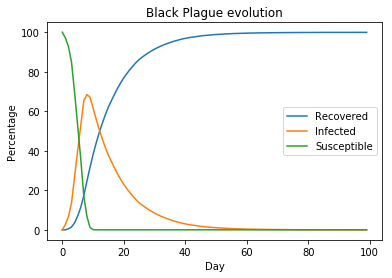

After 30 days (in %):
Healthy:  0.0490918016691
Infected:  9.39541558098
Dead:  90.5554926173
It takes 7 days before 60% of the population is infected
It takes 15 days before 60% of the population is dead


In [2]:
#Returns SIR distribution and percentages per day 
def epidemics(sim):

    infected = []
    recovered = []
    susceptible = []

    #np.where gives us the indexes of the entries of the array fulfilling the condition as a 1-tuple,
    #hence the recovered[0]. Note that this method works because of the ordering and denomination of nodes.
    for i in range(100):
        inf = np.where(sim.inf_time <= i)
        rec = np.where(sim.rec_time <= i)
        true_inf = np.setdiff1d(inf, rec)
        susc = np.setdiff1d(np.array(G.nodes()),inf)
        infected.append(true_inf)
        susceptible.append(susc)
        recovered.append(rec[0])

    infected = np.array(infected)
    recovered = np.array(recovered)
    susceptible = np.array(susceptible)

    infected_perc = np.array([len(e)*100.0 / sim.n_nodes for e in infected])
    recovered_perc = np.array([len(e)*100.0 / sim.n_nodes for e in recovered])
    susceptible_perc = np.array([len(e)*100.0 / sim.n_nodes for e in susceptible])
    
    return (infected,recovered,susceptible),(infected_perc,recovered_perc,susceptible_perc)

#Plots SIR percentages per day
def plot_epidemics_and_stats(data):
    plt.title("Black Plague evolution")
    plt.plot(data[1])
    plt.plot(data[0])
    plt.plot(data[2])
    plt.legend(["Recovered", "Infected", "Susceptible"])
    plt.xlabel("Day")
    plt.ylabel("Percentage")
    plt.show()
    
    print("After 30 days (in %):")
    print("Healthy: ",data[2][29])
    print("Infected: ",data[0][29])
    print("Dead: ",data[1][29])
    
x,y = epidemics(sir)
plot_epidemics_and_stats(y)

#First access the array in the 1-tuple then access its first element
print("It takes {days} days before 60% of the population is infected".format(days=np.where(y[0]>=60)[0][0]))
print("It takes {days} days before 60% of the population is dead".format(days=np.where(y[1]>=60)[0][0]))


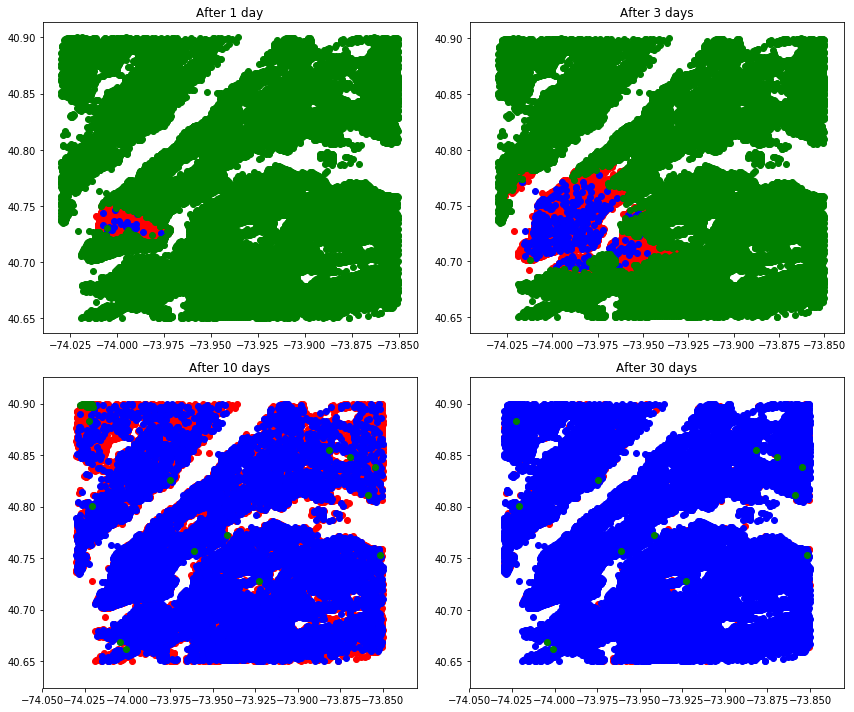

In [3]:
#We decide to scale down the coordinates to double digits for better readability
def coordinates(data):
    coords = [G.nodes()[n]["coordinates"] for n in data]
    converted_coords = [(c[0]/(10**6), c[1]/(10**6)) for c in coords]
    x =[c[0] for c in converted_coords]
    y =[c[1] for c in converted_coords]
    return x,y

def visualize_plague(triple, days):
    inf_x, inf_y = coordinates(triple[0][days])
    rec_x, rec_y = coordinates(triple[1][days])
    susc_x, susc_y = coordinates(triple[2][days])
    
    plt.scatter(inf_x,inf_y, c='r')
    plt.scatter(rec_x,rec_y, c='b')
    plt.scatter(susc_x,susc_y, c='g')

plt.figure(figsize=(12,10))
plt.subplot(221)
plt.title("After 1 day")
visualize_plague(x,1)
plt.subplot(222)
plt.title("After 3 days")
visualize_plague(x,3)
plt.subplot(223)
plt.title("After 10 days")
visualize_plague(x,10)
plt.subplot(224)
plt.title("After 30 days")
visualize_plague(x,30)
plt.tight_layout()
plt.show()   
    

# **Black Plague Visualization**

### -  Infected = Red
### -  Dead = Blue
### - Susceptible = Green

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

Epidemic stopped after 100.46 days | 100.46 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Epidemic stopped after 107.41 days | 107.41 days elapsed | 0.3% susceptible, 0.0% infected, 99.6% recovered
Epidemic stopped after 100.05 days | 100.05 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Epidemic stopped after 106.13 days | 106.13 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Epidemic stopped after 101.45 days | 101.45 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered


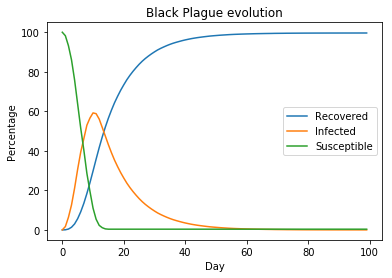

After 30 days (in %):
Healthy:  0.368566141762
Infected:  10.5804161474
Dead:  89.0510177108


In [4]:
#We shuffle the list instead of calling random.choice n times since it does not work on lists of tuples
def random_edges_removed(graph,n):
    edges = list(graph.edges())
    np.random.shuffle(edges)
    deleted = edges[:n]
    graph.remove_edges_from(deleted)

#Given a graph, runs the epidemic multiple times to obtain average stats
def avg_sim(g,n):
    sim = epidemics_helper.SimulationSIR(g, beta=10.0, gamma=0.1)
    inf_avg = np.zeros(100)
    rec_avg = np.zeros(100)
    susc_avg = np.zeros(100)
    
    for i in range(n):
        source_rd = np.random.choice(g.nodes())
        sim.launch_epidemic(source=source_rd,max_time=100.0)
        a,b = epidemics(sim)
        
        inf_avg += b[0]
        rec_avg += b[1]
        susc_avg += b[2]
    
    inf_avg /= n
    rec_avg /= n
    susc_avg /= n
    
    return inf_avg, rec_avg, susc_avg

G_bis1 = G.copy()
random_edges_removed(G_bis1,1000)

data_avg = avg_sim(G_bis1,5)
plot_epidemics_and_stats(data_avg)

This strategy is obviously not effective at all since it does not take into account the structure of the graph.

Epidemic stopped after 103.26 days | 103.26 days elapsed | 23.7% susceptible, 0.0% infected, 76.2% recovered
Epidemic stopped after 111.80 days | 111.80 days elapsed | 23.7% susceptible, 0.0% infected, 76.3% recovered
Epidemic stopped after 100.31 days | 100.31 days elapsed | 24.1% susceptible, 0.0% infected, 75.9% recovered
Epidemic stopped after 103.60 days | 103.60 days elapsed | 23.7% susceptible, 0.0% infected, 76.3% recovered
Epidemic stopped after 101.77 days | 101.77 days elapsed | 23.8% susceptible, 0.0% infected, 76.2% recovered
Epidemic stopped after 72.60 days | 72.60 days elapsed | 98.4% susceptible, 0.0% infected, 1.6% recovered
Epidemic stopped after 103.59 days | 103.59 days elapsed | 23.7% susceptible, 0.0% infected, 76.3% recovered
Epidemic stopped after 102.95 days | 102.95 days elapsed | 24.0% susceptible, 0.0% infected, 76.0% recovered
Epidemic stopped after 106.35 days | 106.35 days elapsed | 66.9% susceptible, 0.0% infected, 33.1% recovered
Epidemic stopped after

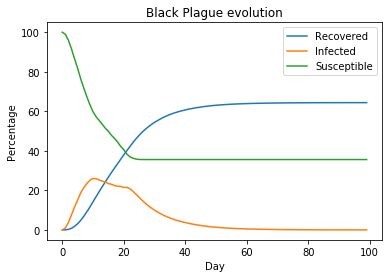

After 30 days (in %):
Healthy:  35.599108795
Infected:  11.0501869265
Dead:  53.3507042785


In [5]:
G_bis2 = G.copy()
random_edges_removed(G_bis2,10000)

data_avg2 = avg_sim(G_bis2,10)
plot_epidemics_and_stats(data_avg2)

Obviously by shutting down a significant part of the network we do much better (even though we are still subject to randomness).

#### Exercise 2.11: Strategy 2

We adopted many strategies that proved fruitless:
-  Find and remove high degree nodes
-  Find and remove articulation points
-  Find and remove bridges

Our final strategy is the following:  
-  For every edge in the graph, we compute its betweenness centrality as seen in class, 
$ f(e) = \sum \frac{sigma(u,v|e)}{sigma(u,v)} $ i.e the sum over every pair of vertices u,v of the number of shortest paths between the two vertices  going through e divided by the number of shortest paths between the two vertices  
-  We then sort the edges according to their betweenness centrality coefficient and remove the top 2500 ones  

Basically we are trying to increase paths lengths between vertices in order to let the infected vertices get removed before spreading  the disease throughout the network.

The result is shown in a picture below since the algorithm takes 45 minutes to complete.

In [ ]:
import operator

def betweenness_centrality(graph,n):
    g = graph.copy()
    remove = nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(remove.items(), key=operator.itemgetter(1), reverse=True)[:n]
    for k,v in sorted_tuples:
        g.remove_edge(*k)
        
    return g

amen = betweenness_centrality(G,2500)

data_avg3 = avg_sim(amen,10)
plot_epidemics_and_stats(data_avg3)
    

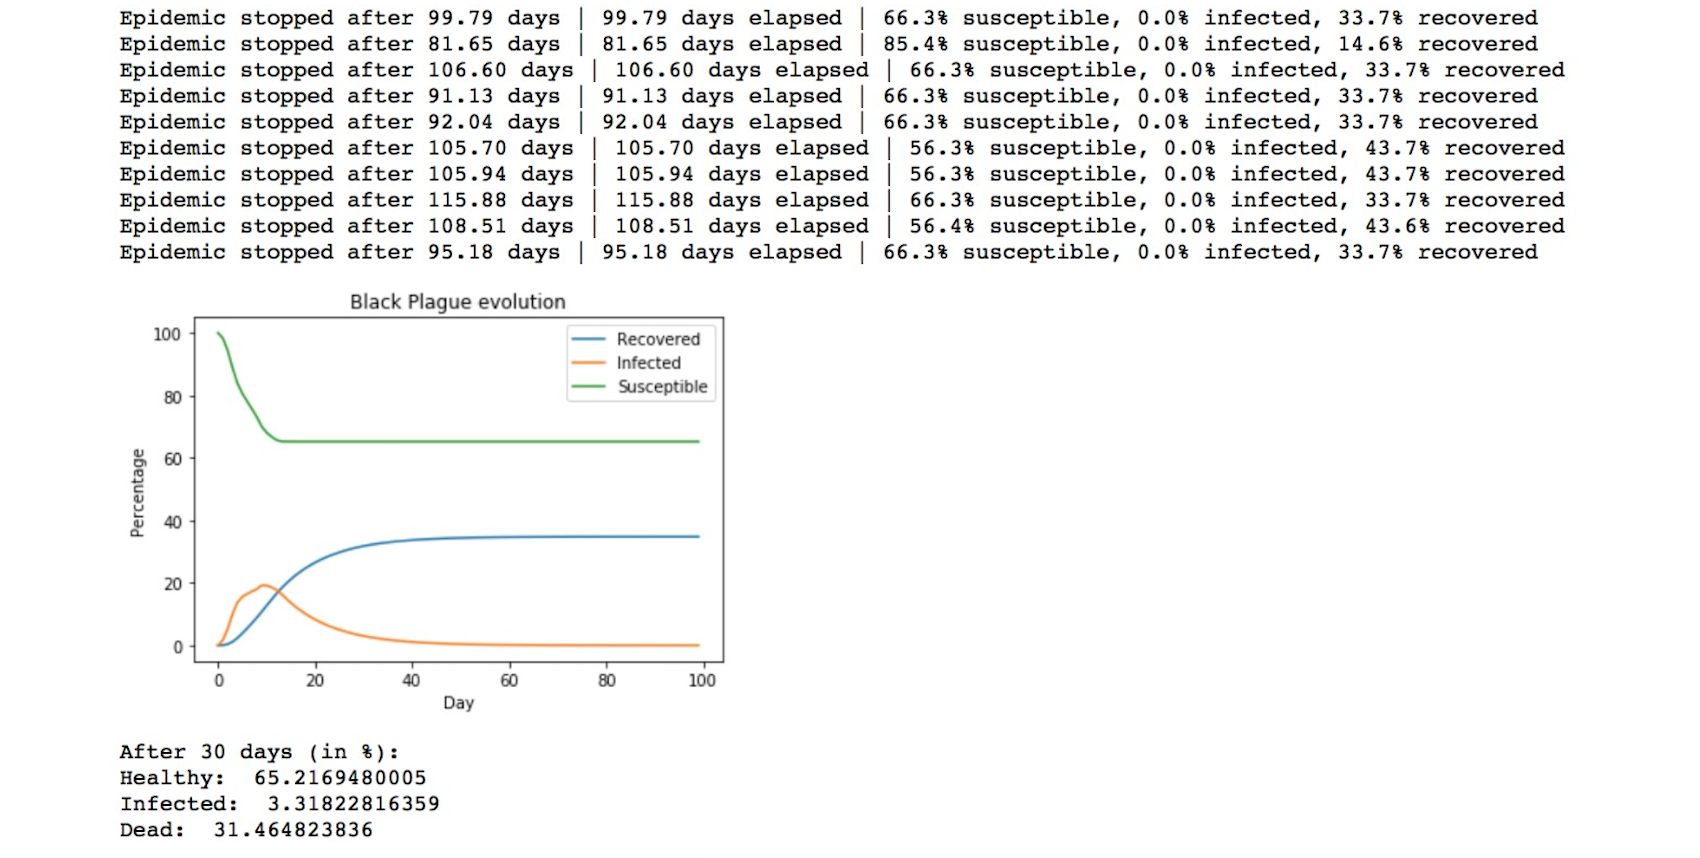

In [1]:
from IPython.display import Image
Image("../data/part3.png")